# Numpy implementation of logistic regression with spike-slab prior

This is a hand-coding version of the logistc regression with spike-slab prior, based on Numpy. This serves as a double check of the result based on PyMC3 from [this project](https://drive.google.com/file/d/161KAaWM-ur6PaqfhNUqpoJMePu8-EosA/view). In that notebook, the biological background has been abstracted out and provides codes with PyMC3 and PyMC4  with different results. In this notebook, we provide a hand-coding version whose model is consistent with the settings.

## Statistical models without biological background

We simulated a data-set containing 1,000 samples with observed binary response ($y \in \{0,1\}$), under logistic regression $\text{logit}(E(y)) = \alpha + X\beta$ where $X$ has 3 variables $x_1 \ne x_2 = x_3$, with effect $\beta_1 = 0, \beta_2 \ne 0, \beta_3 = 0$.

We model variable $j$'s effect using a spike slab prior, $\beta_j \sim \pi_{j} \delta_0 + (1 - \pi_{j}) N (\mu, \sigma^2)$. Due to simulation settings we expect posterior of $\pi$ is close to 0 for $x_1$. Since  $x_2$ and $x_3$ are identical, we expect posterior of $\pi$ also identical for $x_2$ and $x_3$, and are both 0.5.

## Data simulation

In [1]:
import numpy as np
def simulate_logistic(x, b):
    z = x.dot(b)
    p = 1/(1+np.exp(-z))
    return np.random.binomial(1., p).astype(np.float32)

def get_X(n,p,seed=999):
    np.random.seed(seed)
    x1 = np.random.binomial(1,p,n)
    x2 = np.random.binomial(1,p,n)
    x3 = x2
    return np.vstack([x1, x2, x3]).T.astype(np.float32)

seed = 999
b = [0,1,0]
X = get_X(1000,0.2,seed)
y = simulate_logistic(X,b)

In [2]:
X.shape

(1000, 3)

In [3]:
y.shape

(1000,)

### Some global parameters

In [9]:
iteration = 2000
tune_prop = 0.1
n_chain = 3
n_thread = 4
target_accept = 0.95

pi0 = 0.051366009925488
mu = 0.783230896500752
sigma = 0.816999481742865
lower = -2.94
upper = 0
target_accept = 0.95

## PyMC3 spike-slab logistic regression

In [10]:
import pymc3 as pm3
import theano.tensor as tt

def bvsr_pm3(y, X, pi0=0.5, mu=0, sigma=1, lower=-1, upper=1):
    invlogit = lambda x: 1/(1 + tt.exp(-x))
    model = pm3.Model()
    with model:
        xi = pm3.Bernoulli('xi', pi0, shape = X.shape[1])
        beta_offset = pm3.Normal('beta_offset', mu = 0, sd = 1, shape = X.shape[1])
        beta = pm3.Deterministic("beta", mu + beta_offset * sigma)
        alpha_offset = pm3.Uniform("alpha_offset", lower = -1, upper = 1)
        alpha = pm3.Deterministic("alpha", lower + (alpha_offset+1)/2*(upper - lower))
        p = pm3.math.dot(X, xi * beta)
        y_obs = pm3.Bernoulli('y_obs', invlogit(p + alpha), observed = y)
    return model

m3 = bvsr_pm3(Y,X, pi0, mu, sigma, lower, upper)
with m3:
    trace3 = pm3.sample(draws = iteration, random_seed = seed, cores = n_thread, progressbar = True, chains = n_chain, tune = int(tune_prop*iteration), nuts = {"target_accept": target_accept})

<ipython-input-10-57a6c9ae47a4>:19: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace3 = pm3.sample(draws = iteration, random_seed = seed, cores = n_thread, progressbar = True, chains = n_chain, tune = int(tune_prop*iteration), nuts = {"target_accept": target_accept})
Multiprocess sampling (3 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [xi]
>NUTS: [alpha_offset, beta_offset]


Sampling 3 chains for 200 tune and 2_000 draw iterations (600 + 6_000 draws total) took 1673 seconds.
The number of effective samples is smaller than 25% for some parameters.


## PyMC3 result

### Trace

<ipython-input-11-d00582c693e1>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  status = pm3.traceplot(trace3)
/Users/jungang/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


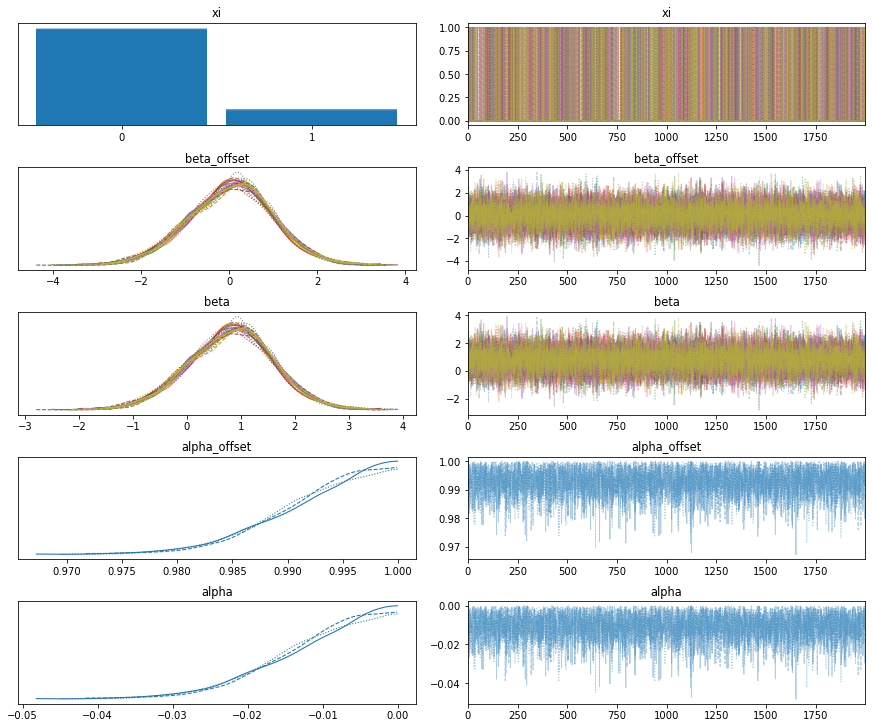

In [11]:
status = pm3.traceplot(trace3)

### Posterior estimate of $\pi$

We expect them to be (0, 0.5, 0.5)

In [14]:
np.apply_along_axis(np.mean, 0, trace3['beta'])

array([0.82141675, 0.80514379, 0.80001621, 0.80539277, 0.83077356,
       0.79967673, 0.82844438, 0.8059892 , 0.82876865])

### Posterior estimate of $\alpha$
We expect it be 0.

In [13]:
np.mean(trace3['alpha'])

-0.009924668846469436

## Hand-writing NUTS-MH Block Sampler of Posterior Distribution

#### In this part, we rename variable $\pi$ as g, to avoid some inconvenience in coding.

In this part, we provided a hand-writing version of naive No-U-Turn Sampler algorithm (a type of Hamiltonian Monte Carlo sampling) to the posterior distribution. As we know, HMC is well-known monte carlo method for high-dimensional data. The basic idea is borrowed from Hamilton System, which is a classical dynamic system in physics. A brief introduction of HMC can be found [here](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo).

Followed by the instruction of the steps of HMC in [Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/), we need to calculate the derivatives of log-posterior distribution of each parameters and samples based on the idea of Hamiltonian System. After a series of sampling, a accept-reject process are proposed to decide the quality of sampling.

However, HMC has several disadvantages. The most inconvenient one is that we need to tune 3 hyperparameters by hand: Mass Matrix(approximate to posterior variance), step size and step number. In empirical study, if these parameters are not well tuned, the MCMC chains are very hard to mix up and converge. In order to solve this problem, an advanced HMC algorithm call No-U-Turn Sampler(NUTS) are proposed in the [paper](https://arxiv.org/abs/1111.4246). Based on some complex mechanisms, these 3 parameters are tuned automatically.

Although HMC(or NUTS) is a rather powerful and efficient tool to sample, it can be only applied to continuous variables. In our setting, variable $g$ is a binary variable, which cannot be sampled by HMC. So, we use NUTS to sample continuous variables and Metropolis-Hastings to sample binary variable. These 2 parts consist of the whole NUTS-MH block sampler.


#### Likelihood: 

$y \sim Bernoulli( sigmoid (X(\beta \odot g)  + \alpha ))$,   where $sigmoid(x)=\frac{1}{1 + e^{-x}}$,   $\odot$ means element-wise product


#### Prior: 

$g \sim \prod Bernoulli(pi0)$

$\beta \sim \prod Normal(\mu, \sigma^2)$

$\alpha \sim Uniform(lower + (upper - lower) * \frac{lower + 1}{2}, lower + (upper - lower) * \frac{upper + 1}{2})$

where pi0, $\mu$, $\sigma^2$, lower, upper are hyperparameters.


#### Joint Posterior:

$p(g,\alpha,\beta|y,x) \varpropto p(y|g, \beta, \alpha, x)p(\alpha|x) p(\beta | x) p(g | x) =  \prod^n \{(sigmoid(X_i(\beta \odot g) + \alpha))^{y_i}(1 - sigmoid(X_i(\beta \odot g) + \alpha))^{1 - y_i} \} * exp(-\frac{(\beta - \mu)^{'}{(\beta - \mu)}}{2 \sigma^2}) * \prod (pi0)^{g} * (1 - pi0)^{1 - g} *  I\{\alpha \in (lower + (upper - lower) * \frac{1}{2}, lower + (upper - lower))\}$


##### Log-posterior partial derivative:

$\frac{\partial{logp}}{\partial g_j} = \sum_i^n \{ y_i X_{ij} \beta_{j} - sigmoid(x_i (\beta \odot g) + \alpha) * x_{ij} \beta_j \}  + log(\frac{pi0}{1 - pi0})$,  (this derivative of discrete variable cannot be used in HMC)

$\frac{\partial{logp}}{\partial \alpha} = \sum_i^n \{ sigmoid(-x_i(\beta \odot g) - \alpha) - (1- y_i) \}$, where $\alpha \in (lower + (upper - lower) * \frac{1}{2}, lower + (upper - lower))$

$\frac{\partial{logp}}{\partial \beta_j} = \sum_i^n \{ sigmoid(-x_i(\beta \odot g) - \alpha) * x_{ij} g_j + (1-y_i)(-x_{ij} g_j) \} - \frac{(\beta_j - \mu)}{\sigma^2} $

After carefully calculate the partial derivative of each parameter for log-posterior density, basic HMC sampling algorithm will be exploited to sample $\alpha$, $\beta$.

Since the $\alpha$ need to be in an accept region with constrain, we simply use the suggestion from [Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/), where we reverse the direction of momentum variable when $\alpha$ reaches the rejected region.


##### Update for $g_i$ :
Metropolis-Hastings algorithm will be applied to sample $g_i$, since NUTS can only be used for continuous variables. In this sense, random sample $gi_{new} \sim Bernoulli(0.5)$ is the transition kernel, where all the transition probabilities from $gi_{old}$ to $gi_{new}$ are equal, to reduce some computations of M-H algorithm.



##### Algorithm of HMC(NUTS):

In [5]:
# define the log-posterior partial derivative functions and log-posterior density functions

sigmoid = lambda x:1/(1 + np.exp(-x))


# the log unnormalized posterior probability of all parameters
def log_posterior(X, y, g, beta, alpha, mu, sigma2, pi0, tol = 1e-100):
    logp = (y * np.log(sigmoid(np.dot(X, beta*g) + alpha) + tol) + (1 - y) * np.log(1 - sigmoid(np.dot(X, (beta * g) + tol) + alpha))).sum() - (beta - mu).T.dot(beta - mu) / (2 * sigma2) + g.sum() * np.log(pi0) + np.log(1 - pi0) * (g.size - g.sum())
    return logp

# the partial derivative of log unnormalized posterior probability of g_j
def dlogp_dgj(X, y, g, beta, alpha, pi0, j, tol = 1e-100):
    pd = (y * X[:, j] * beta[j] - sigmoid(X.dot(beta * g) + alpha) * X[:, j] * beta[j]).sum() + np.log(pi0 / (1 - pi0) + tol)
    return pd

# the partial derivative of log unnormalized posterior probability of alpha
def dlogp_dalpha(X, y, g, beta, alpha):
    pd = y - sigmoid(np.dot(X, beta * g) + alpha)
    return pd.sum()

# the partial derivative of log unnormalized posterior probability of beta_j
def dlogp_dbetaj(X, y, g, beta, alpha, mu, sigma2, j):
    pd = (y * X[:, j] * g[j] - sigmoid(X.dot(beta * g) + alpha) * X[:, j] * g[j]).sum() - (beta[j] - mu) / sigma2
    return pd

# the log unnormalized marginal posterior probability of g_j
def marginal_logpost_g(X, y, g, beta, alpha, pi0, j, tol = 1e-100):
    pg = (y * np.log(sigmoid(X.dot(beta * g) + alpha) + tol) + (1 - y) * np.log(1 - sigmoid(X.dot(beta * g) + alpha) + tol)).sum() + np.log(pi0 + tol) * g[j] + np.log(1 - pi0 + tol) * g[j]
    return pg




In [6]:
# sampling algorithm
from scipy.stats import multivariate_normal


def alpha_in_region(lower, upper, alpha):
    # check whether the sampled alphas are in the accepted region
    l = lower + (upper - lower) * (0 + 1) / 2
    r = lower + (upper - lower) * (1 + 1) / 2
    if alpha >= l and alpha <= r:
        return True
    else:
        return False


def update_g(X, y, g, beta, alpha, pi0, accept_n):
    # update g by Metropolis-Hasting Algorithm
    g_new = np.random.binomial(n = 1, p = 0.5, size = g.size)
    log_r = 0
    for k in range(X.shape[1]):
        log_r += marginal_logpost_g(X, y, g_new, beta, alpha, pi0, k)
        log_r -= marginal_logpost_g(X, y, g, beta, alpha, pi0, k)
    if log_r > np.log(np.random.rand(1)[0]):
        accept_n += 1
        return g_new, accept_n
    else:
        return g, accept_n
    
def BuildTree(X, y, g, beta, alpha, phi, u, v, j, e, delta_max = 1000):
    # build binary sampling tree 
    if j == 0:
        e = v * e
        dlogp_beta = []
        dlogp_alpha = [dlogp_dalpha(X, y, g, beta, alpha)]
        for k in range(X.shape[1]):
            dlogp_beta.append(dlogp_dbetaj(X, y, g, beta, alpha, mu, sigma**2, k))
        dlogp = np.concatenate([dlogp_beta, dlogp_alpha])
        phi = phi + 0.5 * e * dlogp
        
        # update parameter
        p = np.concatenate((beta, alpha))
        p = p + e * phi
        beta = p[:beta.size]
        alpha = np.array([p[beta.size]])
        
        
        # half step   update momentum
        dlogp_beta = []
        dlogp_alpha = [dlogp_dalpha(X, y, g, beta, alpha)]
        for k in range(X.shape[1]):
            dlogp_beta.append(dlogp_dbetaj(X, y, g, beta, alpha, mu, sigma**2, k))
        dlogp = np.concatenate([dlogp_beta, dlogp_alpha])
        phi = phi + 0.5 * e * dlogp
        
        if not alpha_in_region(lower, upper, alpha):
            # if alpha is not in the accepted region, then reverse the direction of momentum
            phi[-1] *= -1
            
        if alpha_in_region(lower, upper, alpha) and np.log(u) <= (log_posterior(X, y, g, beta, alpha, mu, sigma**2, pi0) - 0.5 * (phi).T.dot(phi)):
            C2 = [(beta.copy(), alpha, phi.copy())] 
        else:
            C2 = []
        s2 = np.log(u) < delta_max + log_posterior(X, y, g, beta, alpha, mu, sigma**2, pi0) - 0.5 * (phi).T.dot(phi)
        return beta.copy(), alpha, phi.copy(), beta.copy(), alpha, phi.copy(), C2, s2
    else:
        beta_negative, alpha_negative, phi_negative, beta_positive, alpha_positive, phi_positive, C2, s2 = BuildTree(X, y, g, beta.copy(), alpha, phi.copy(), u, v, j - 1, e)
        if v == -1:
            beta_negative, alpha_negative, phi_negative, _,_,_, C3, s3 = BuildTree(X, y, g, beta_negative.copy(), alpha_negative, phi_negative.copy(), u, v, j - 1, e)
        else:
            _,_,_, beta_positive, alpha_positive, phi_positive, C3, s3 = BuildTree(X, y, g, beta_positive.copy(), alpha_positive, phi_positive.copy(), u, v, j - 1, e)
        positive = np.concatenate([beta_positive, alpha_positive])
        negative = np.concatenate([beta_negative, alpha_negative])
        s2 = s2 * s3 * ((positive - negative).T.dot(phi_negative) >= 0) * ((positive - negative).T.dot(phi_positive) >= 0)
        C2 = C2 + C3
        return beta_negative.copy(), alpha_negative, phi_negative.copy(), beta_positive, alpha_positive, phi_positive.copy(), C2, s2
    
def update_NUTS(X, y, g, beta, alpha, pi0, e, mu, sigma, lower, upper):
    # update beta and alpha by NUTS Algorithm
    phi = np.random.multivariate_normal(np.zeros(beta.size + alpha.size),  np.diag(np.ones(beta.size + alpha.size)))
    u = np.random.random() * np.exp(log_posterior(X, y, g, beta, alpha, mu, sigma**2, pi0) - 0.5 * (phi).T.dot(phi))
    g_negative = g.copy()
    g_positive = g.copy()
    beta_negative = beta.copy()
    beta_positive = beta.copy()
    alpha_negative = alpha
    alpha_positive = alpha
    phi_negative = phi.copy()
    phi_positive = phi.copy()
    j = 0
    C = [(beta.copy(), alpha, phi.copy())]
    s = 1
    while s == 1:
        v_j = np.random.choice([-1, 1])
        if v_j == -1:
            beta_negative, alpha_negative, phi_negative, _,_,_, C2, s2 = BuildTree(X, y, g, beta_negative.copy(), alpha_negative, phi_negative.copy(), u, v_j, j, e)
        else:
            _,_,_, beta_positive, alpha_positive, phi_positive, C2, s2 = BuildTree(X, y, g, beta_positive.copy(), alpha_positive, phi_positive.copy(), u, v_j, j, e)
        if s2 == 1:
            C = C + C2
        positive = np.concatenate([beta_positive, alpha_positive])
        negative = np.concatenate([beta_negative, alpha_negative])
        s = s2 * ((positive - negative).T.dot(phi_negative) >= 0) * ((positive - negative).T.dot(phi_positive) >= 0)
        j = j + 1
    return C[np.random.choice(len(C))]
                  
          
  


def MCMC(burnings, samples, sampling_gap, X, y, g, beta, alpha, pi0, mu, sigma, lower, upper, e = 0.1, progress_bar = True):
    if progress_bar == True:
        from tqdm import tqdm

        
        # burning phrase
        MH_accept_n = 0
        print("burn-in phrase:", end = "")
        for i in tqdm(range(burnings)):
            g, MH_accept_n = update_g(X, y, g, beta, alpha, pi0, MH_accept_n)
            beta, alpha, phi = update_NUTS(X, y, g, beta, alpha, pi0, e, mu, sigma, lower, upper)
        print("MH accept rate in burning phrase:", MH_accept_n / burnings)
        print()
        # sampling phrase
        g_samples = []
        beta_samples = []
        alpha_samples = []
        MH_accept_n = 0
        print("sampling phrase:", end = "")
        for i in tqdm(range(samples * sampling_gap)):
            g, MH_accept_n = update_g(X, y, g, beta, alpha, pi0, MH_accept_n)
            beta, alpha, phi = update_NUTS(X, y, g, beta, alpha, pi0, e, mu, sigma, lower, upper)
            if i % sampling_gap == 0:
                # sampling each sample by a gap
                g_samples.append(g)
                beta_samples.append(beta)
                alpha_samples.append(alpha)
        print("MH accept rate in sampling phrase:", MH_accept_n / (samples * sampling_gap))
        return np.stack(g_samples), np.stack(beta_samples), np.stack(alpha_samples)
        
    else:
        for i in range(burnings):
            g, MH_accept_n = update_g(X, y, g, beta, alpha, pi0, MH_accept_n)
            beta, alpha, phi = update_NUTS(X, y, g, beta, alpha, pi0, e, mu, sigma, lower, upper)
        print("MH accept rate in burning phrase:", MH_accept_n / burnings)
        print()

        # sampling phrase
        g_samples = []
        beta_samples = []
        alpha_samples = []
        MH_accept_n = 0

        for i in range(samples * sampling_gap):
            g, MH_accept_n = update_g(X, y, g, beta, alpha, pi0, MH_accept_n)
            beta, alpha, phi = update_NUTS(X, y, g, beta, alpha, pi0, e, mu, sigma, lower, upper)
            if i % sampling_gap == 0:
                # sampling each sample by a gap
                g_samples.append(g)
                beta_samples.append(beta)
                alpha_samples.append(alpha)
        print("MH accept rate in sampling phrase:", MH_accept_n / (samples * sampling_gap))
        return np.stack(g_samples), np.stack(beta_samples), np.stack(alpha_samples)


##### Sample only a chain

In [7]:
# sample the initial positions of parameters from prior distribution
g = np.random.binomial(1, 0.5, X.shape[1])
beta = np.random.normal(0, 1, X.shape[1])
alpha = np.random.uniform(lower + (upper - lower) * (1) / 2, lower + (upper - lower) * (1 + 1) / 2, [1])


# sample a chain. Here set step size as 0.01
chain_one = MCMC(1000, 1000, 2, X, y, g, beta, alpha, pi0, mu, sigma, lower, upper, e = 0.01)
chain_one

  0%|          | 2/1000 [00:00<00:52, 19.16it/s]

burn-in phrase:

  0%|          | 1/2000 [00:00<03:41,  9.04it/s]

MH accept rate in burning phrase: 0.154
sampling phrase:

100%|██████████| 2000/2000 [03:13<00:00, 10.35it/s]

MH accept rate in sampling phrase: 0.153


(array([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        ...,
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]]),
 array([[ 0.93008436,  1.02878379,  0.8669758 ],
        [ 0.45916246, -0.6223015 ,  0.94555494],
        [ 0.51645782, -0.56196753,  0.89465529],
        ...,
        [ 2.3954833 ,  0.97982543,  2.04424813],
        [ 2.37454872,  1.0255947 ,  2.04103199],
        [ 2.63967597,  1.05083345,  1.66006662]]),
 array([[-1.62776539e-02],
        [-5.24693343e-02],
        [-4.62230334e-02],
        [-9.63898820e-02],
        [-7.27303273e-02],
        [-5.95182756e-02],
        [-1.09853603e-01],
        [-5.97412058e-02],
        [-9.07356279e-03],
        [-8.88088541e-02],
        [-5.71781576e-02],
        [-6.65223477e-03],
        [-3.84893730e-02],
        [-1.30190038e-01],
        [-5.75535683e-02],
        [-7.11153530e-02],
        [-5.58697914e-02],
        [-6.31454851e-02],
        [-6.76332598e-02],
        [-1.22788027e-03],
        [-8.73710052e-

##### Convergence Diagnostic

After finishing the sampling part, we need to test the convergence of MCMC chains. Therefore, [Gelman-Rubin statistic](https://www.jstor.org/stable/2246093?seq=1) is applied to do diagnostics. In this part, we first write a function to sample multiple chains and then call diagnostic function.

In [ ]:
from joblib import Parallel, delayed
import multiprocessing
def Parallel_MCMC(n_chains, burnings, samples, sampling_gap, X, y, pi0, mu, sigma, lower, upper, e = 0.01):
    # this is the function for sampling multiple chains
    
    # randomly sample starting points of each chain
    parameters = []
    for i in range(n_chains):
        g = np.random.binomial(1, 0.5, X.shape[1])
        beta = np.random.normal(0, 1, X.shape[1])
        alpha = np.random.uniform(lower + (upper - lower) * (1) / 2, lower + (upper - lower) * (1 + 1) / 2, [1])
        parameters.append([burnings, samples, sampling_gap, X.copy(), y.copy(), g.copy(), beta.copy(), alpha.copy(), pi0, mu, sigma, lower, upper, e, False])
    
    # run MCMC by parallel computing
    num_cores = multiprocessing.cpu_count()
    results = Parallel(n_jobs=num_cores)(delayed(MCMC)(i[0], i[1], i[2], i[3], i[4], i[5], i[6], i[7], i[8], i[9], i[10], i[11], i[12], i[13], i[14]) for i in parameters)
    return results

from chainconsumer import ChainConsumer
def MCMC_diagnostic(chains, parameter_name, threshold = 1.1, walkers = 2):
    # this function is used to do convergence diagnostics
    
    # add chain to Chain Consumer
    c = ChainConsumer()
    for i in range(len(chains)):
        chain = np.concatenate(chains[i], axis = 1)
        c.add_chain(chain, walkers=walkers, parameters= parameter_name, name= str(i + 1))

    # using the Gelman-Rubin statistic
    gelman_rubin_converged = c.diagnostic.gelman_rubin(threshold = threshold)
    print()
    return gelman_rubin_converged

In [ ]:
# sample for 4 chains
multiple_chains = Parallel_MCMC(4, 1000, 1000, 2, X, y, pi0, mu, sigma, lower, upper, e = 0.01)
multiple_chains

In [ ]:
# set parameter names in diagnostic function
parameter_name = ["g_1", "g_2", "g_3"] + ["beta_" + str(z) for z in range(X.shape[1])] + ["alpha"]
print("parameter names:", parameter_name)

print()
print()

# do convergence diagnostics
print("The chains of MCMC pass the convergence diagnostic:", MCMC_diagnostic(multiple_chains, parameter_name))

#### Trace Plot for the first Chain in Parallel MCMC

##### g

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

g_samples1 = multiple_chains[0][0]
for i in range(g_samples1.shape[1]):
    chain = g_samples1[:, i]
    num, count = np.unique(chain, return_counts = True)
    plt.figure(figsize=(15,6))
    plt.subplot(121)
    plt.bar(num, count)
    plt.title('Density Plot for g' + str(i + 1))
    plt.xticks([0, 1])
    #plt.hist(chain, density = True, nbins = 100)
    plt.subplot(122)
    plt.plot(np.arange(chain.shape[0]),chain)
    plt.title('Trace Plot for g' + str(i + 1))
    plt.show()
    

##### $\beta$

In [ ]:
beta_samples1 = multiple_chains[0][1]
#beta_samples1 = chain_one[1]
#print(beta_samples1)
for i in range(beta_samples1.shape[1]):
    chain = beta_samples1[:, i]
    plt.figure(figsize=(15,6))
    plt.subplot(121)
    sns.histplot(chain,  kde=True, stat = "density", binwidth= 0.1)
    plt.title('Density Plot for $\\beta$' + str(i + 1))
    plt.xlim(-5, 5)
    
    plt.subplot(122)
    plt.plot(np.arange(chain.shape[0]),chain)
    plt.title('Trace Plot for $\\beta$' + str(i + 1))
    plt.ylim(-10, 10)
    plt.show()
    

##### $\alpha$

In [ ]:
#alpha_samples1 = chain_one[2]
alpha_samples1 = multiple_chains[0][2]
chain = alpha_samples1.reshape(-1)
plt.figure(figsize=(15,6))
plt.subplot(121)
sns.histplot(chain,  kde=True, stat = "density", binwidth= 0.001)
plt.title('Density Plot for $\\alpha$')
#plt.xlim(-5, 5)

plt.subplot(122)
plt.plot(np.arange(chain.shape[0]),chain)
plt.title('Trace Plot for $\\alpha$')
#plt.ylim(-10, 10)
plt.show()

##### Posterior estimate of  g

We expect them to be (0, 0.5, 0.5)

In [ ]:
np.stack(g_samples1).mean(axis = 0)

##### Posterior estimate of $\alpha$
We expect it be 0.

In [ ]:
alpha_samples1.mean()

## Conclusion

From what has been showed above, the result of hand-writing version is consistent with the result from PyMC3. The posterior expectation of $\tilde{g_1}$, $\tilde{g_2}$, $\tilde{g_3}$ are approximately 0, 0.5, 0.5. Also, for $\tilde{\alpha}$, the posterior estimator is very close to 0. These results are what we expected before simulation.

# Test

In [2]:
import pandas as pd

In [3]:
Y = pd.read_table(r"./data/deletion.X.colnames_b30.simu_dele_30_0528.y", sep = "\n", header = 0).to_numpy().reshape(-1)
X = pd.read_table(r"./data/block_557_565").to_numpy()[1:,]
#X.shape
#?pd.read_table

In [10]:
pi0 = 0.5
mu = 0
sigma = 1
lower = -10
upper = 10

In [14]:
# sample the initial positions of parameters from prior distribution
g = np.random.binomial(1, 0.5, X.shape[1])
beta = np.random.normal(0, 1, X.shape[1])
alpha = np.random.uniform(lower + (upper - lower) * (1) / 2, lower + (upper - lower) * (1 + 1) / 2, [1])


# sample a chain. Here set step size as 0.01
chain_one = MCMC(1000, 1000, 2, X, Y, g, beta, alpha, pi0, mu, sigma, lower, upper, e = 0.0)
chain_one

  0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-6-ae194aa26e37>:58: RuntimeWarning: divide by zero encountered in log
  if alpha_in_region(lower, upper, alpha) and np.log(u) <= (log_posterior(X, y, g, beta, alpha, mu, sigma**2, pi0) - 0.5 * (phi).T.dot(phi)):
<ipython-input-6-ae194aa26e37>:62: RuntimeWarning: divide by zero encountered in log
  s2 = np.log(u) < delta_max + log_posterior(X, y, g, beta, alpha, mu, sigma**2, pi0) - 0.5 * (phi).T.dot(phi)
  0%|          | 1/1000 [00:00<01:46,  9.42it/s]

burn-in phrase:

 10%|█         | 100/1000 [10:09<1:31:28,  6.10s/it]


KeyboardInterrupt: 

In [5]:
X[:, 1].sum()

31

In [7]:
X.size

256005